In [125]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.utils import class_weight
from scipy.signal import butter, filtfilt
import seaborn as sns

In [126]:
# TensorFlow 버전 확인
print(f"TensorFlow version: {tf.__version__}")

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            try:
                # 최신 API 사용
                tf.config.set_memory_growth(gpu, True)
                print(f"Set memory growth for GPU: {gpu}")
            except AttributeError:
                # 이전 API 사용
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"Set memory growth for GPU using experimental API: {gpu}")
    except RuntimeError as e:
        print(f"Failed to set memory growth: {e}")
else:
    print("No GPU devices found. Running on CPU.")

TensorFlow version: 2.16.1
Set memory growth for GPU using experimental API: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [127]:
# Step 1: 데이터 로드 함수 (세션 정보 제거)
def load_eeg_data(directory):
    """
    Load raw EEG data and corresponding labels from the specified directory.

    Parameters:
        directory (str): Path to the directory containing .npy files.

    Returns:
        X (np.ndarray): Concatenated EEG data.
        y (np.ndarray): Corresponding labels.
        participants (np.ndarray): Corresponding participant IDs.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    if not files:
        raise FileNotFoundError("No .npy files found in the directory.")

    data_list, labels, participants = [], [], []
    for file in files:
        # Extract participant ID and label from filename
        basename = os.path.basename(file)
        parts = basename.split('_')
        if len(parts) < 5:
            raise ValueError(f"Unexpected file naming format: {basename}")

        participant_id = parts[0]
        label_str = parts[1].lower()

        if 'positive' in label_str:
            label = 1
        elif 'negative' in label_str:
            label = 0
        else:
            raise ValueError(f"File name does not indicate label: {file}")

        raw_data = np.load(file)

        # Check if raw_data has the expected shape (samples, eeg data, channels)
        if len(raw_data.shape) != 3:
            raise ValueError(f"Unexpected data shape {raw_data.shape} in file: {file}")

        # Append raw data and metadata
        data_list.append(raw_data)
        labels.extend([label] * raw_data.shape[0])
        participants.extend([participant_id] * raw_data.shape[0])

    X = np.concatenate(data_list)
    y = np.array(labels)
    participants = np.array(participants)

    return X, y, participants

In [128]:
# Step 2: 밴드패스 필터링 함수
def bandpass_filter(data, lowcut=4, highcut=45, fs=128, order=5):
    """
    Apply a bandpass filter to EEG data.

    Parameters:
        data (np.ndarray): EEG data.
        lowcut (float): Low cutoff frequency.
        highcut (float): High cutoff frequency.
        fs (float): Sampling frequency.
        order (int): Filter order.

    Returns:
        filtered_data (np.ndarray): Filtered EEG data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

In [129]:
# Step 3: 데이터 정규화 함수
def normalize_eeg_data(data):
    """
    Normalize EEG data.

    Parameters:
        data (np.ndarray): EEG data.

    Returns:
        normalized_data (np.ndarray): Normalized EEG data.
    """
    return (data - np.mean(data, axis=-1, keepdims=True)) / np.std(data, axis=-1, keepdims=True)


In [130]:
# Step 4: CNN 모델 정의
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),
        Dropout(0.3),
        
        Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [131]:
# Step 5: 데이터 전처리 함수 (세션 정보 제거)
def preprocess_eeg_data(directory):
    X, y, participants = load_eeg_data(directory)
    X = bandpass_filter(X)
    #X = normalize_eeg_data(X)
    return X, y, participants

In [132]:
# Step 7: 학습 로그 시각화 함수
def plot_training_history(history, fold):
    """
    Plot training and validation loss and accuracy.

    Parameters:
        history (tf.keras.callbacks.History): History object from model training.
        fold (str or int): Fold identifier.
    """
    plt.figure(figsize=(12, 4))
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"training_history_fold_{fold}.png")
    plt.close()
    print(f"Training history plot saved for Fold {fold}.")


In [133]:
# Step 6: Inter-Subject(Session) Cross-Validation을 사용한 Train-Test 분할 및 모델 학습
def train_model_inter_subject_split(X, y, model_path, test_size=0.2):
    """
    Train the CNN model using inter-session cross-validation.
    Ensures that entire participants are either in train or test sets.

    Parameters:
        X (np.ndarray): Preprocessed EEG data.
        y (np.ndarray): Corresponding labels.
        model_path (str): Path to save the trained model.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed.
    """
    # Stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Total training samples: {X_train.shape[0]}")
    print(f"Total testing samples: {X_test.shape[0]}")
    
    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_train_categorical = to_categorical(y_train, num_classes)
    y_test_categorical = to_categorical(y_test, num_classes)

    input_shape = X_train.shape[1:]

    # 클래스 가중치 계산
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Class weights: {class_weights_dict}")

    # Create and train the model
    model = create_cnn_model(input_shape, num_classes)
    
    # 조기 종료 콜백 추가
    from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
    
    history = model.fit(
        X_train, 
        y_train_categorical, 
        epochs=100, 
        batch_size=32, 
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard],
        class_weight=class_weights_dict  # 클래스 가중치 적용
    )
    
    # 학습 로그 시각화
    plot_training_history(history, "Final")
    
    # Step 9: 최적 모델 로드
    #model = tf.keras.models.load_model(checkpoint_filepath)
    
    # Step 10: 모델 평가
    print("\nEvaluating the model on the Test Set...")
    predictions = model.predict(X_test)
    test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)[1]
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # ROC AUC 계산
    if num_classes == 2:
        roc_auc = roc_auc_score(y_test, predictions[:,1])
    else:
        roc_auc = roc_auc_score(y_test_categorical, predictions, multi_class='ovr')
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # F1 Score 계산
    y_pred_labels = np.argmax(predictions, axis=1)
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix 계산
    cm = confusion_matrix(y_test, y_pred_labels)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr_cm = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_cm = tp / (tp + fn) if (tp + fn) > 0 else 0
    else:
        fpr_cm, tpr_cm = None, None  # 다중 클래스의 경우 별도 처리 필요
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    plt.tight_layout()
    plt.savefig("confusion_matrix_inter_session.png")
    plt.close()
    print("Confusion matrix plot saved as 'confusion_matrix_inter_session.png'.")
    
    # ROC Curve 시각화
    plt.figure()
    if num_classes == 2:
        fpr_roc, tpr_roc, _ = roc_curve(y_test, predictions[:,1])
        plt.plot(fpr_roc, tpr_roc, label=f'Class 1 (AUC = {roc_auc:.2f})')
    else:
        for i in range(num_classes):
            fpr_i, tpr_i, _ = roc_curve(y_test_categorical[:, i], predictions[:, i])
            plt.plot(fpr_i, tpr_i, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Save results
    report = classification_report(y_test, y_pred_labels, digits=4)
    print("Detailed Classification Report:")
    print(report)

    with open("bio_cnn_eeg_results_raw_inter.txt", "w") as result_file:
        result_file.write("Inter-Session(Subject) Cross-Validation Results\n")
        result_file.write("\nFinal Accuracy:\n")
        result_file.write(f"{test_accuracy:.4f}\n\n")
        result_file.write("Detailed Classification Report:\n")
        result_file.write(report)
        if fpr_cm is not None and tpr_cm is not None:
            # fpr_cm과 tpr_cm이 배열이 아닌 스칼라인 경우
            # 하지만 혼동 행렬의 경우 이진 분류일 때만 스칼라로 계산
            result_file.write(f"\nFalse Positive Rate (FPR): {fpr_cm:.4f}\n")
            result_file.write(f"True Positive Rate (TPR): {tpr_cm:.4f}\n")
        result_file.write("\nPrediction Details (file-level):\n")
        for i in range(len(y_test)):
            pred = y_pred_labels[i]
            actual = y_test[i]
            correctness = "Correct" if pred == actual else "Incorrect"
            result_file.write(f"Sample {i+1}: Predicted={pred}, Actual={actual} ({correctness})\n")

    # Save the trained model
    model.save(model_path)
    print(f"Model saved at {model_path}")

In [134]:
# Main execution block
def main():
    # 데이터 경로 설정
    data_dir = "/home/bcml1/2025_EMOTION/DEAP_EEG/4s_seg_conv_ch_BPF"  # 실제 데이터가 있는 디렉토리로 업데이트
    model_path = "4seg_cnn_model_inter_session.h5"  # 모델 저장 경로 (확장자 .h5)

    print("Preprocessing EEG data...")
    X, y, participants = preprocess_eeg_data(data_dir)

    print("Starting Inter-Session Cross-Validation...")
    train_model_inter_subject_split(X, y, model_path, test_size=0.2)  # 80:20 분할


Preprocessing EEG data...
Starting Inter-Session Cross-Validation...
Total training samples: 2576
Total testing samples: 644
Class weights: {0: 1.0125786163522013, 1: 0.9877300613496932}
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5380 - loss: 1.5972 - val_accuracy: 0.5291 - val_loss: 0.9433
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5993 - loss: 0.9230 - val_accuracy: 0.5543 - val_loss: 0.9379
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6129 - loss: 0.8673 - val_accuracy: 0.5581 - val_loss: 1.0186
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6340 - loss: 0.8364 - val_accuracy: 0.5736 - val_loss: 1.1167
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6979 - loss: 0.7914 - val_accuracy: 0.5678 - val_loss: 1.1456
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6920 - loss: 0.8038 - val_accuracy: 0.5853 - val_loss: 1.2134
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

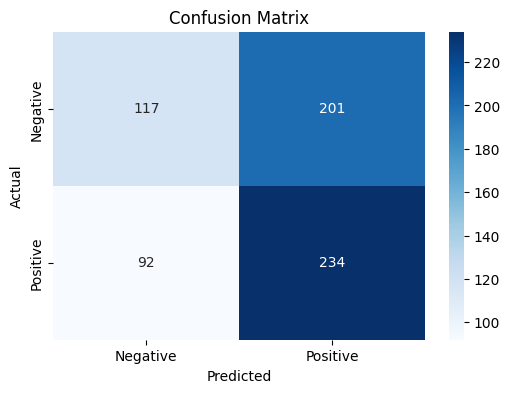

Confusion matrix plot saved as 'confusion_matrix_inter_session.png'.


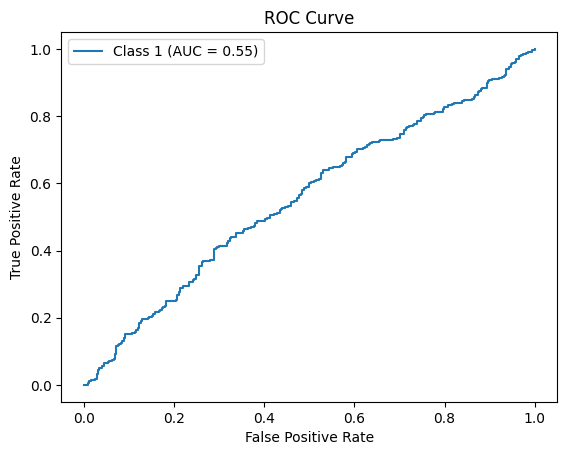

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.5598    0.3679    0.4440       318
           1     0.5379    0.7178    0.6150       326

    accuracy                         0.5450       644
   macro avg     0.5489    0.5429    0.5295       644
weighted avg     0.5487    0.5450    0.5306       644

Model saved at 4seg_cnn_model_inter_session.h5


In [135]:
if __name__ == "__main__":
    main()